Notes: 
 - consistent colors for all methods
 - bold or somehow distinguish the `random` and `oracle` methods

In [1]:
library(tidyverse)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [159]:
results = bind_rows(
    read_csv("data/experimental_results.csv"), 
    read_csv("data/experimental_results_2.csv"))

Parsed with column specification:
cols(
  model = col_character(),
  selection_method = col_character(),
  true_hte_error = col_double(),
  true_value = col_double(),
  DGP = col_character(),
  n_train = col_double(),
  n_test = col_double(),
  n_folds = col_integer(),
  rep = col_integer()
)
Parsed with column specification:
cols(
  model = col_character(),
  selection_method = col_character(),
  true_hte_error = col_double(),
  true_value = col_double(),
  DGP = col_character(),
  n_train = col_double(),
  n_test = col_double(),
  n_folds = col_integer(),
  rep = col_integer()
)


In [160]:
oracle_error = function(error, method, oracle_name) {
    return(error[method==oracle_name])
}

In [216]:
all_methods = results %>% pull(selection_method) %>% unique
method_types = list(
    framework_methods = c("trans_decision", "trans_mse", "match_decision", "match_mse"),
    value_methods = c("gain", "trans_decision", "value"),
    ranking_methods = c("value_auc", "c_benefit", "qini"),
    misc_methods = c("est_te_strata"),
    comparator_methods = c("oracle", "oracle_selector_true_hte_error", "oracle_selector_true_value", "random", "prediction_error")
)

In [162]:
rb_col = brewer.pal(4,"Spectral")
bl_col = brewer.pal(3,"Blues")
pr_col = brewer.pal(3,"Purples")
br_col = c("saddlebrown", "sandybrown", "sienna2")

darken = function(color, factor=1.4){
    col = col2rgb(color)
    col = col/factor
    col = rgb(t(col), maxColorValue=255)
    col
}

In [210]:
method_renames = c(
    'random' = "Random",
    'match_mse'= "Covariate matched-pairs ITE MSE",
    'trans_mse'= "Transformed outcome ITE MSE",
    'match_decision' = "Covariate matched-pairs ITE decision cost",
    'trans_decision'= "Transformed outcome ITE decision cost (neg. generalized gain)",
    'gain' = "Traditional gain",
    'value'= "Decision value",
    'c_benefit' = "C-for-benefit",
    'qini'= "Qini coefficient (gain-at-k AUC)", 
    'value_auc'= 'Value-at-k AUC',
    'est_te_strata' = "Est. treatment effect strata ITE MSE",
    'prediction_error'= "Outcome prediction MSE"
)

In [187]:
method_fills = c(
    'random' = "grey",
    'match_mse'=rb_col[1],
    'trans_mse'=rb_col[2],
    'match_decision'=rb_col[3],
    'trans_decision'=rb_col[4],
    'gain'= bl_col[1],
    'value'= bl_col[2],
    'c_benefit' = pr_col[1],
    'qini'= pr_col[2], 
    'value_auc'= pr_col[3],
    'est_te_strata' = "pink",
    'prediction_error'= "wheat"
) 
# names(method_fills) = method_renames
method_colors = method_fills %>%
    map_chr(darken) %>%
    c
# names(method_colors) = method_renames

In [201]:
rel_results = results %>%
    mutate(assignment = ifelse(str_detect(DGP, "biased"), "biased", "unbiased")) %>%
    mutate(DGP = str_replace(DGP, "biased_", "")) %>%
    mutate(DGP = str_replace(DGP, "_", " ")) %>%
    group_by(DGP, n_folds, rep, n_train, n_test, assignment) %>%
    mutate(rel_true_hte_error = true_hte_error/oracle_error(true_hte_error, selection_method, "oracle_selector_true_hte_error")) %>%
    mutate(rel_true_value = true_value-oracle_error(true_value, selection_method, "oracle_selector_true_value")) %>%
    mutate(selection_method = factor(selection_method, levels=names(method_renames)))

In [211]:
full_error_plot = function(rel_results, fills, colors, methods) {
    rel_results %>%
        filter(selection_method %in% methods) %>%
    ggplot(aes(x=as.factor(DGP), y=log(rel_true_hte_error), fill=selection_method, color=selection_method)) +
        geom_boxplot() +
        scale_fill_manual(name="Selection method", values = fills, labels = method_renames) + 
        scale_color_manual(name="Selection method", values = colors, labels = method_renames) + 
        facet_grid(n_folds~assignment) +
        xlab("Data-generating process") + 
        ylab("log(selected model error) - log(best model error)") +
        theme_bw()
}

full_value_plot = function(rel_results, fills, colors, methods) {
    rel_results %>%
        filter(selection_method %in% methods) %>%
    ggplot(aes(x=as.factor(DGP), y=log(rel_true_value+1), fill=selection_method, color=selection_method)) +
        geom_boxplot() +
        scale_fill_manual(name="Selection method", values = fills, labels = method_renames) + 
        scale_color_manual(name="Selection method", values = colors, labels = method_renames) + 
        facet_grid(n_folds~assignment) +
        xlab("Data-generating process") + 
        ylab("log(selected model value - best model value)") +
        theme_bw()
}

plot_util = function(rel_results, fills, colors, method_type_name, methods) {
    tMSE = full_error_plot(rel_results, fills, colors, methods)
    cost = full_value_plot(rel_results, fills, colors, methods)
    ggsave()
}

# Framework Methods

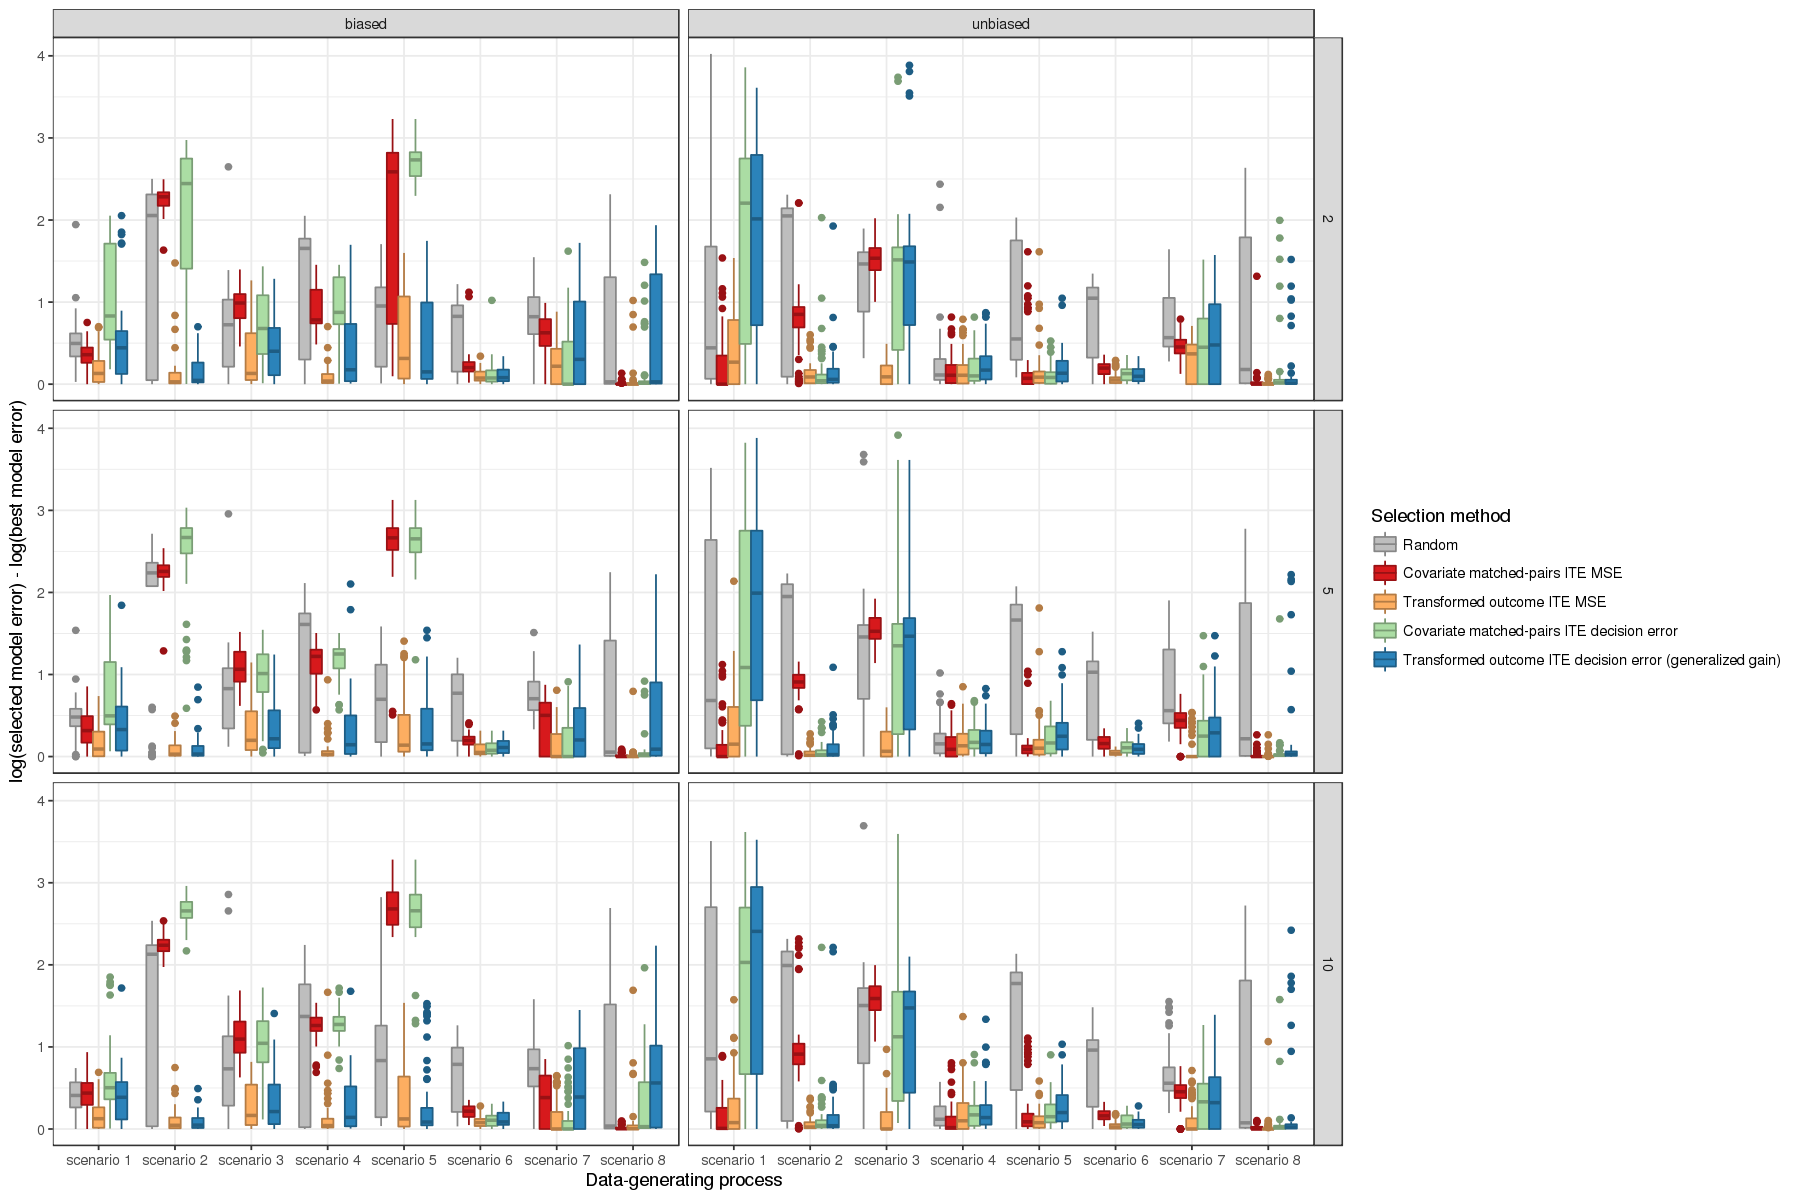

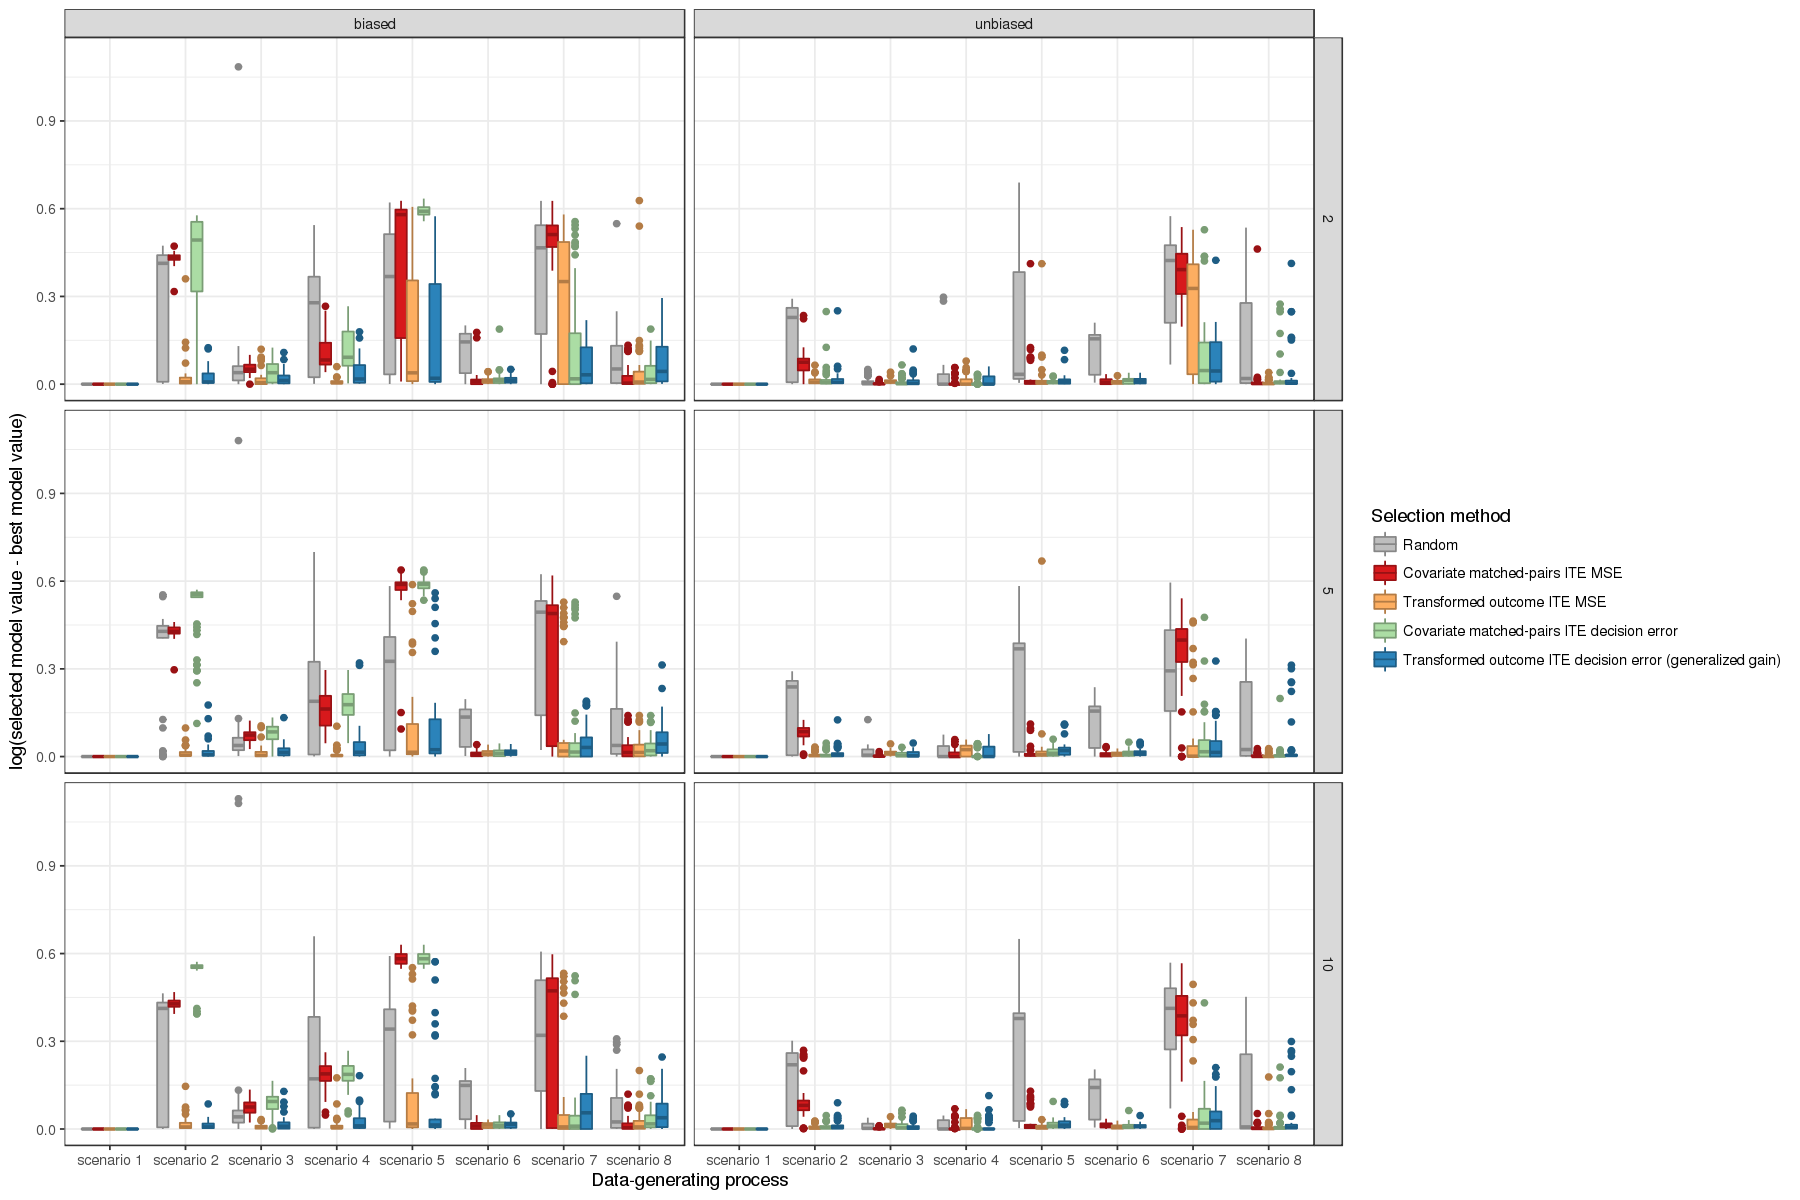

In [212]:
options(repr.plot.width=15, repr.plot.height=10)
full_error_plot(rel_results, method_fills, method_colors, c(framework_methods,"random"))
full_value_plot(rel_results, method_fills, method_colors, c(framework_methods,"random"))

In general, `Random` works decently because all of the models that are being selected from are reasonable.

`trans_mse` also seems to be doing well in terms of value. The decision-based metrics do well here, but again matching seems to hurt relative to weighting (probably because we're using the true .In terms of HTE error, `trans_mse` appears to work the best the most consistently. Matching and descision hurt a bit, trans and mse help. Number of folds doesn't matter that much. 

# Value Methods

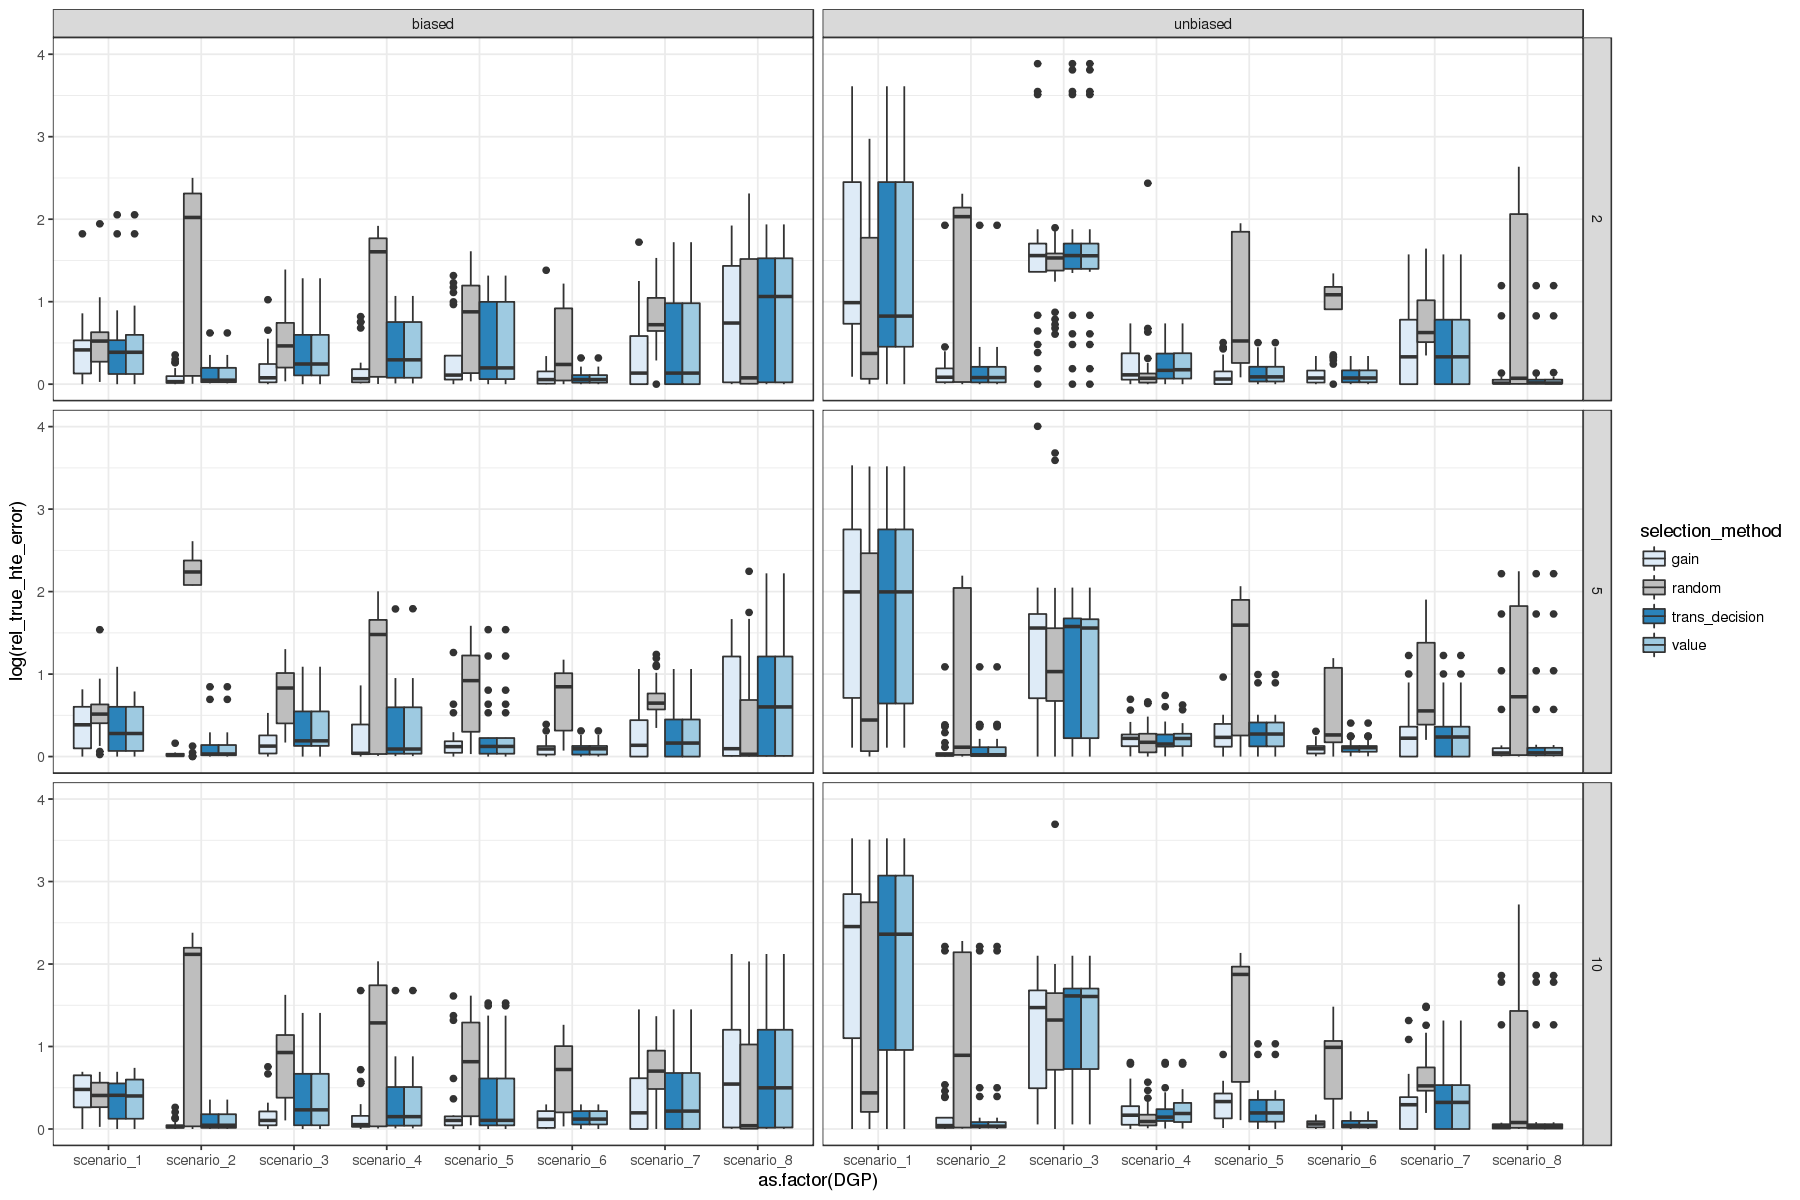

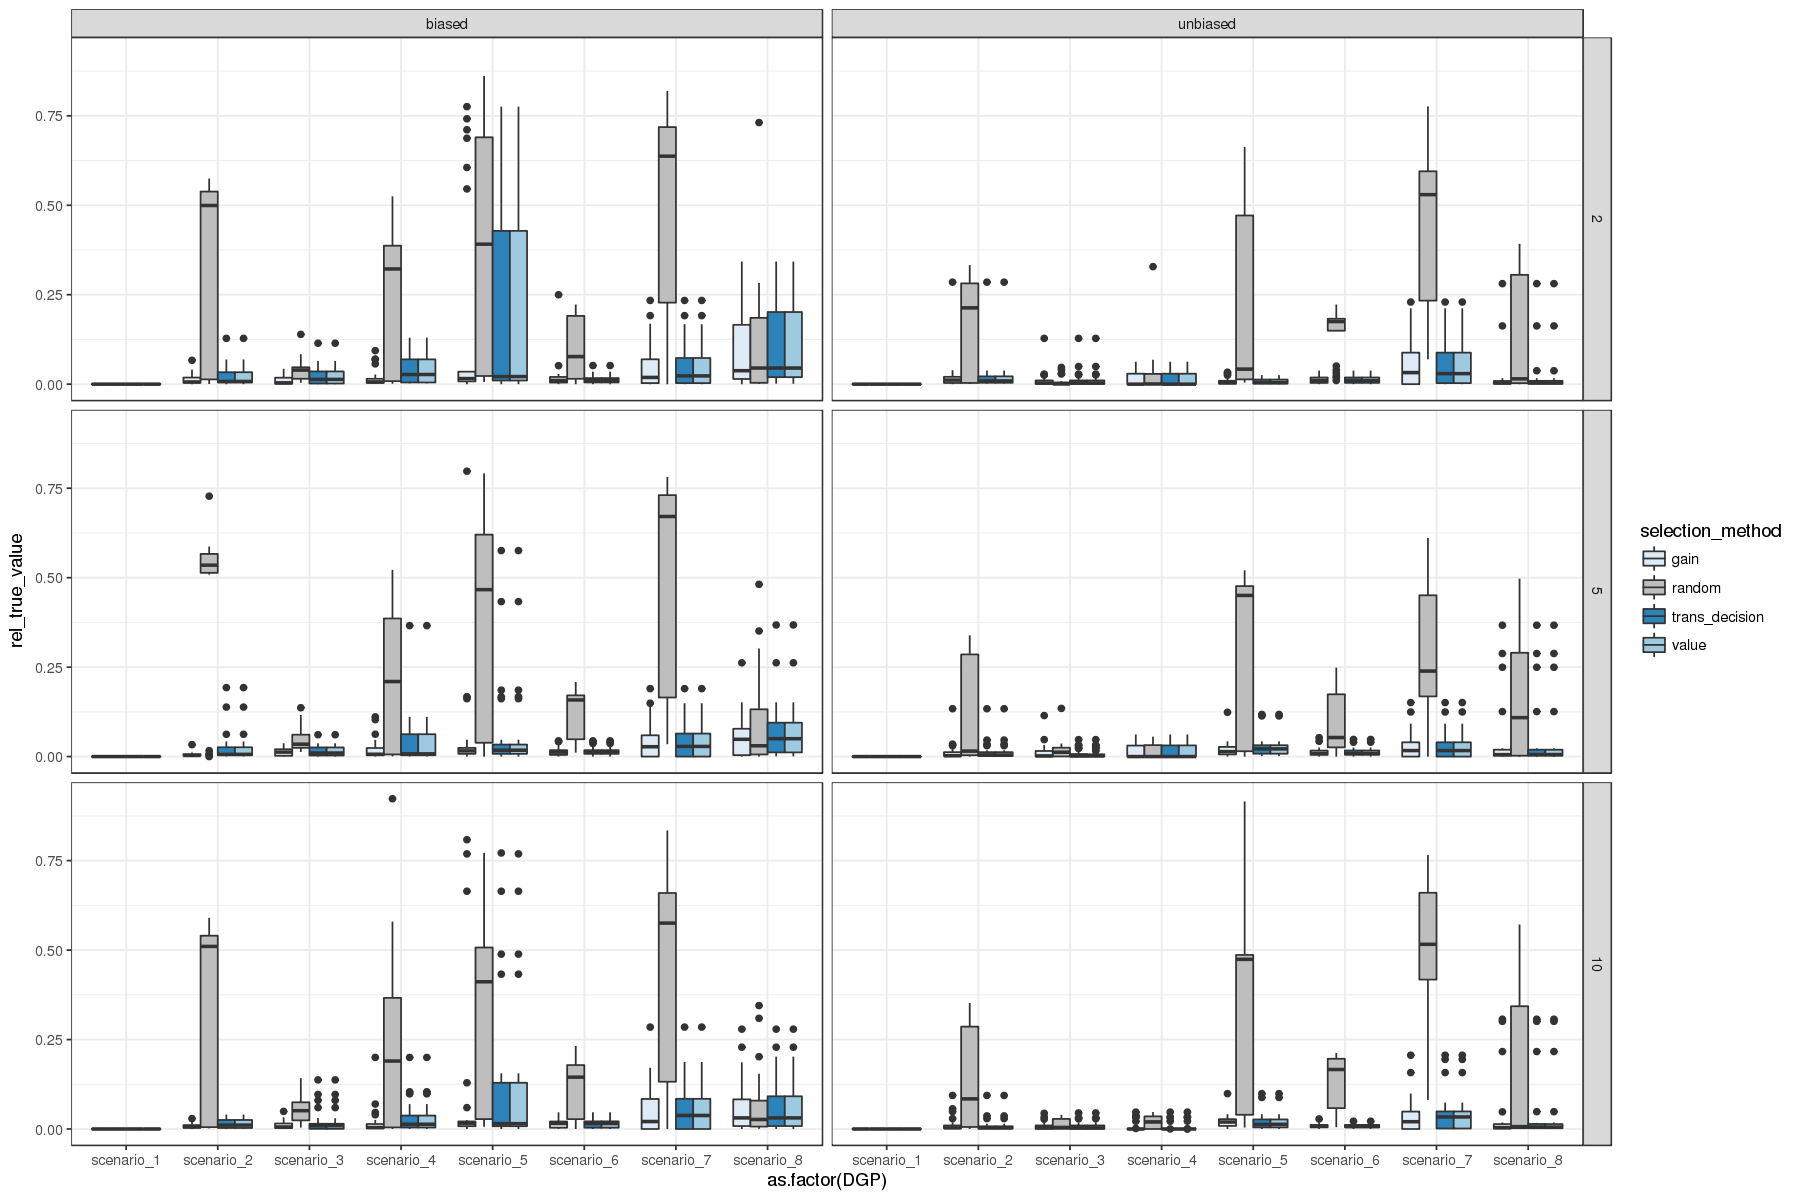

In [121]:
options(repr.plot.width=15, repr.plot.height=10)
rel_results %>%
filter(selection_method %in% value_methods | selection_method == "random") %>%
ggplot(aes(x=as.factor(DGP), y=log(rel_true_hte_error), fill=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_colors) + 
    facet_grid(n_folds~assignment) + 
    theme_bw()

rel_results %>%
filter(selection_method %in% value_methods | selection_method == "random") %>%
ggplot(aes(x=as.factor(DGP), y=rel_true_value, fill=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_colors) + 
    facet_grid(n_folds~assignment) + 
    theme_bw()

These all do the exact same thing, as expected. Gain is a little different than the other two, but only in the biased assignment scenario because its estimating a group-wise propensity there whereas the other two have access to the true propensities.

# Ranking Methods

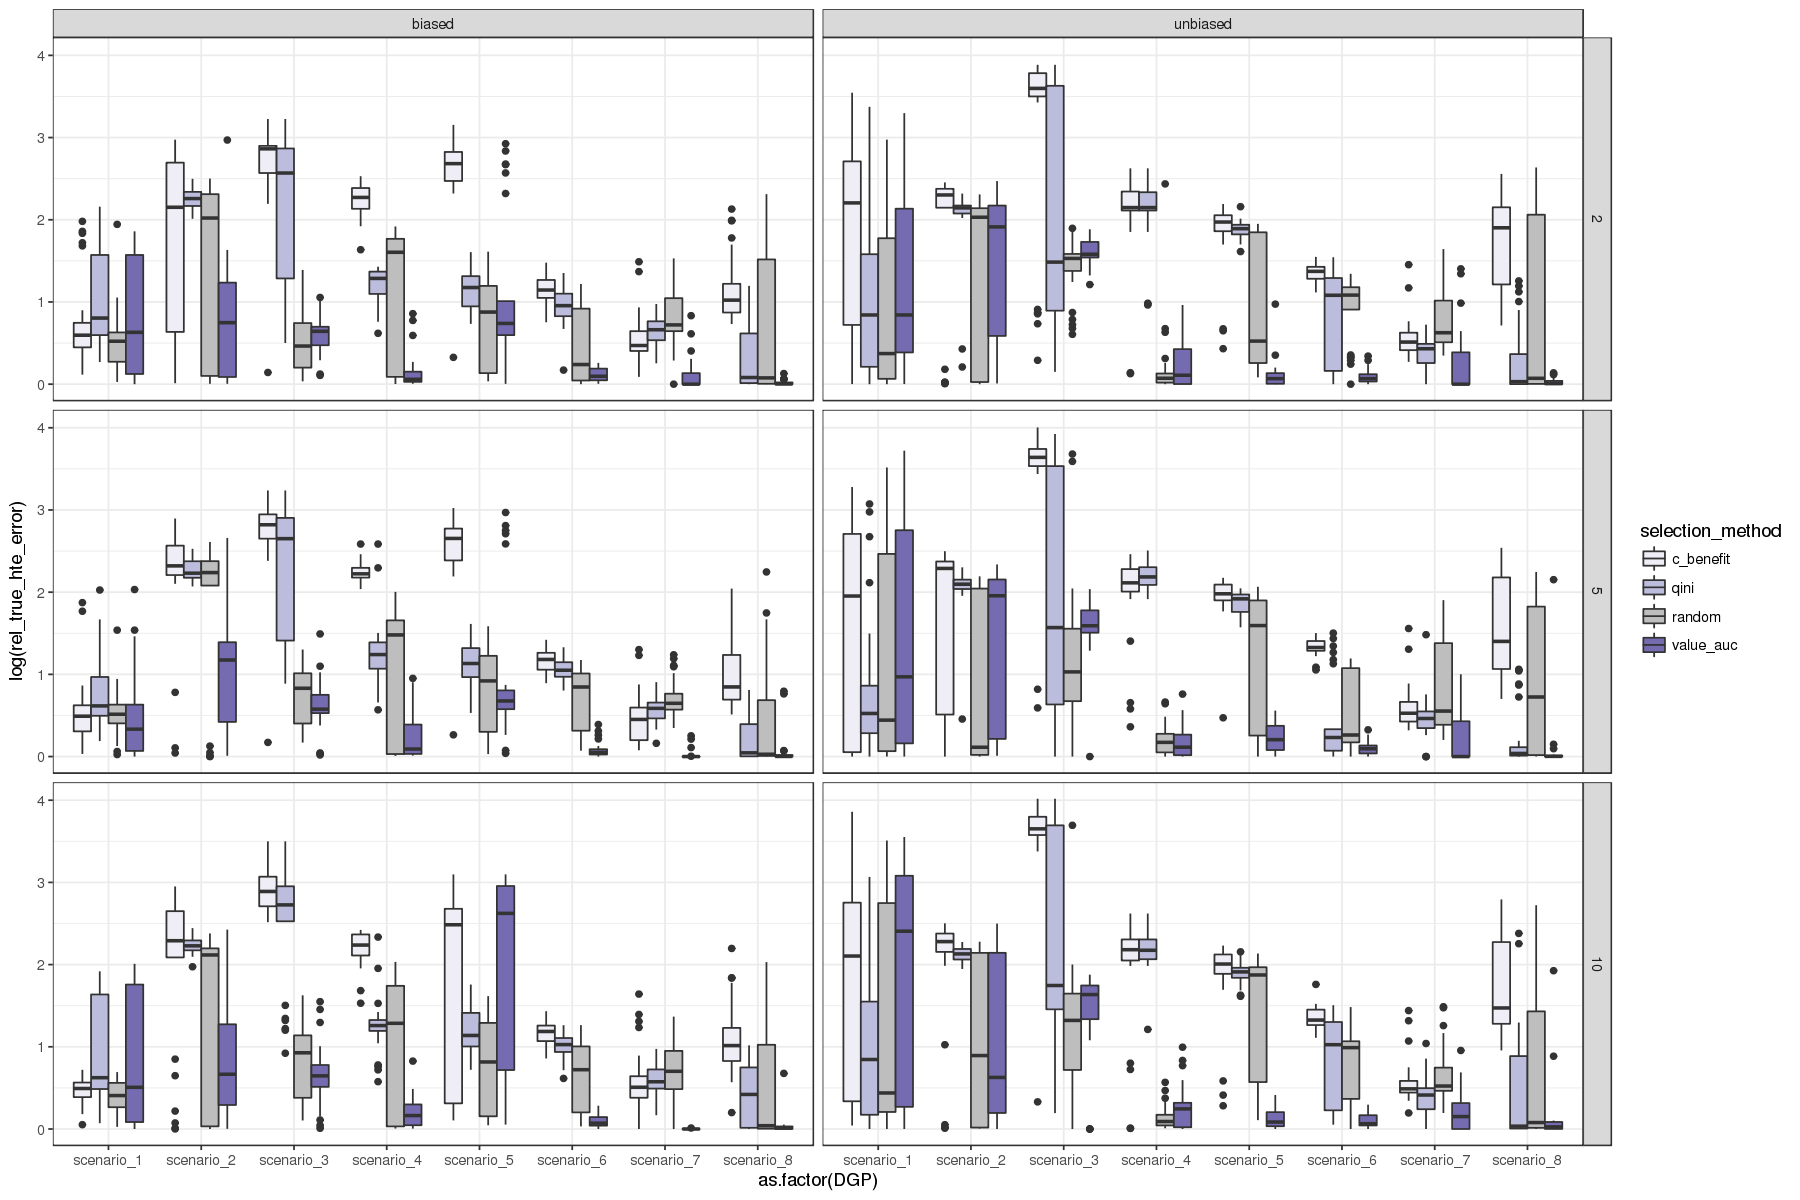

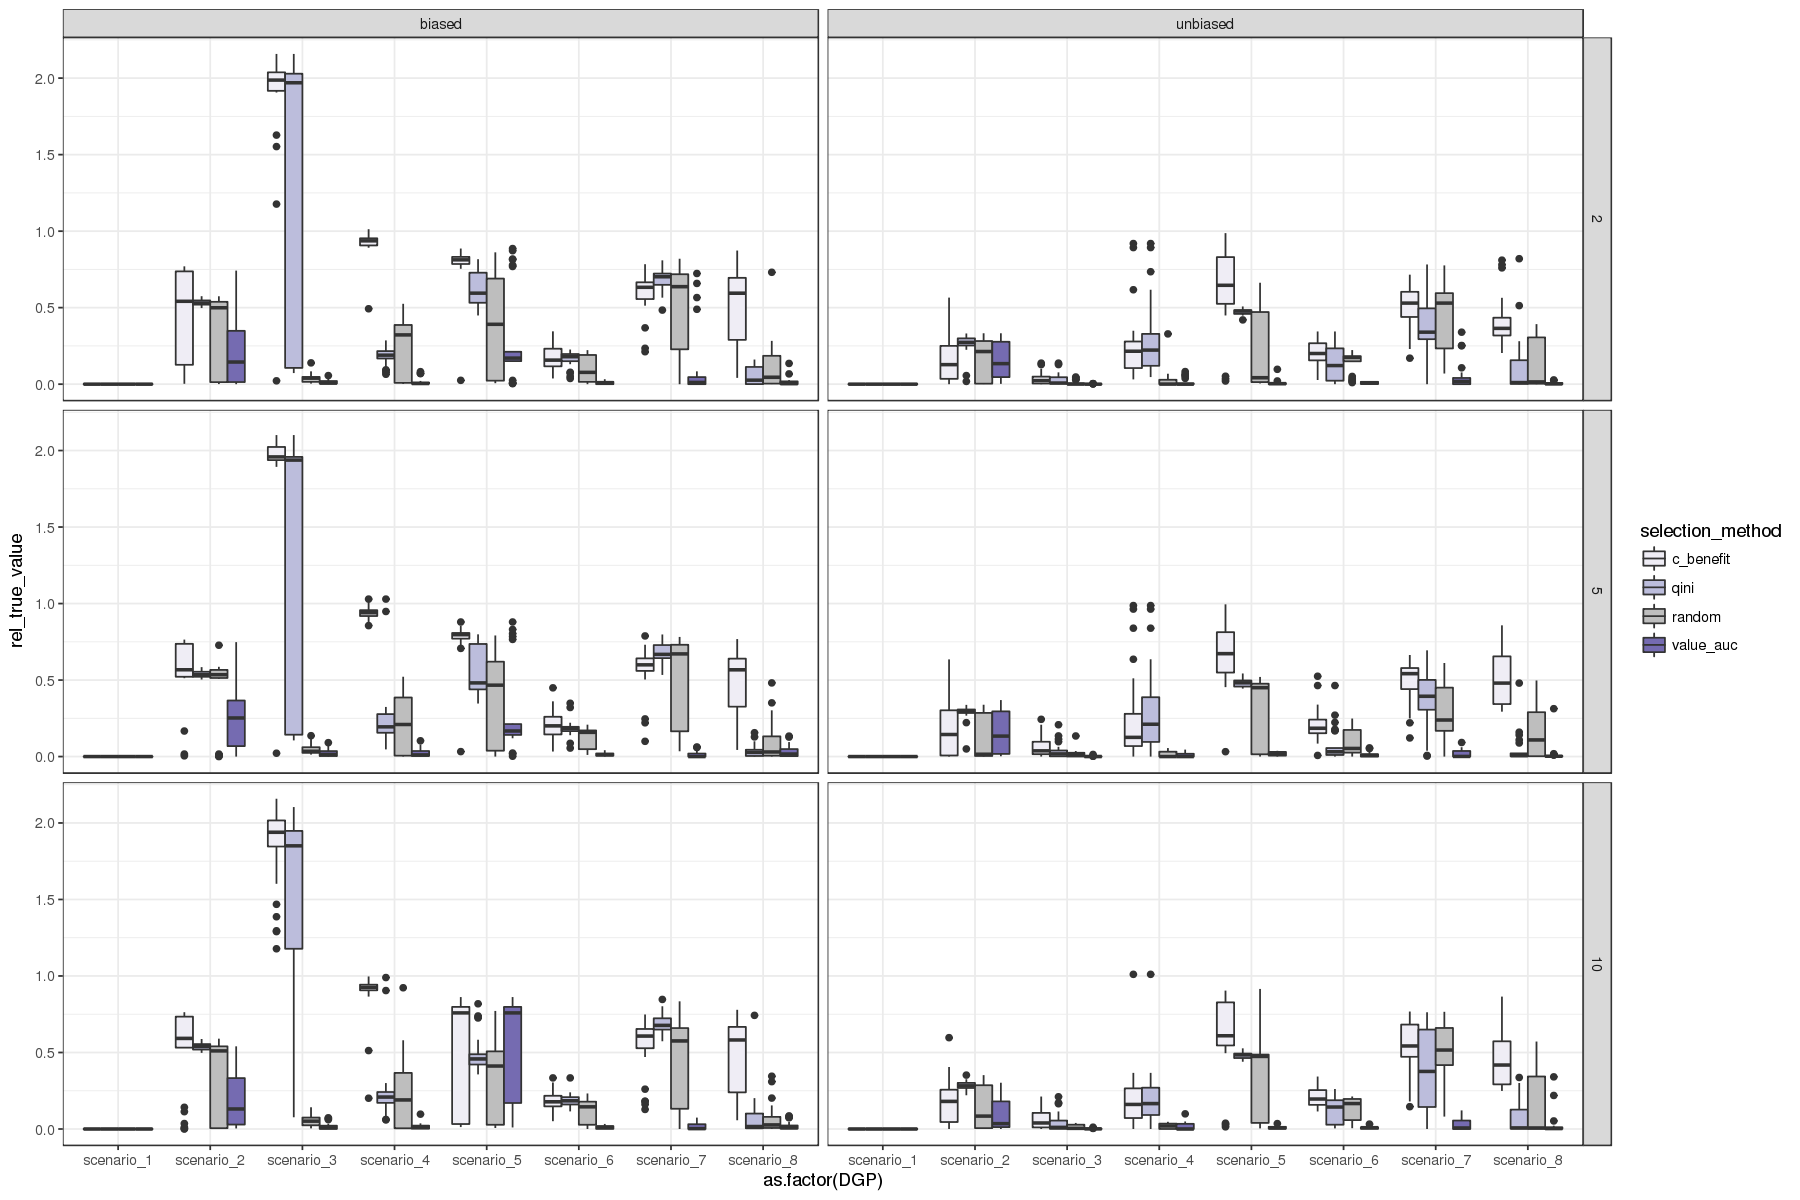

In [122]:
options(repr.plot.width=15, repr.plot.height=10)
rel_results %>%
filter(selection_method %in% ranking_methods | selection_method == "random") %>%
ggplot(aes(x=as.factor(DGP), y=log(rel_true_hte_error), fill=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_colors) + 
    facet_grid(n_folds~assignment) + 
    theme_bw()

rel_results %>%
filter(selection_method %in% ranking_methods | selection_method == "random") %>%
ggplot(aes(x=as.factor(DGP), y=rel_true_value, fill=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_colors) + 
    facet_grid(n_folds~assignment) + 
    theme_bw()

These all kinda suck. `value_auc` is the only one that consistently does better than random.

# Misc Methods

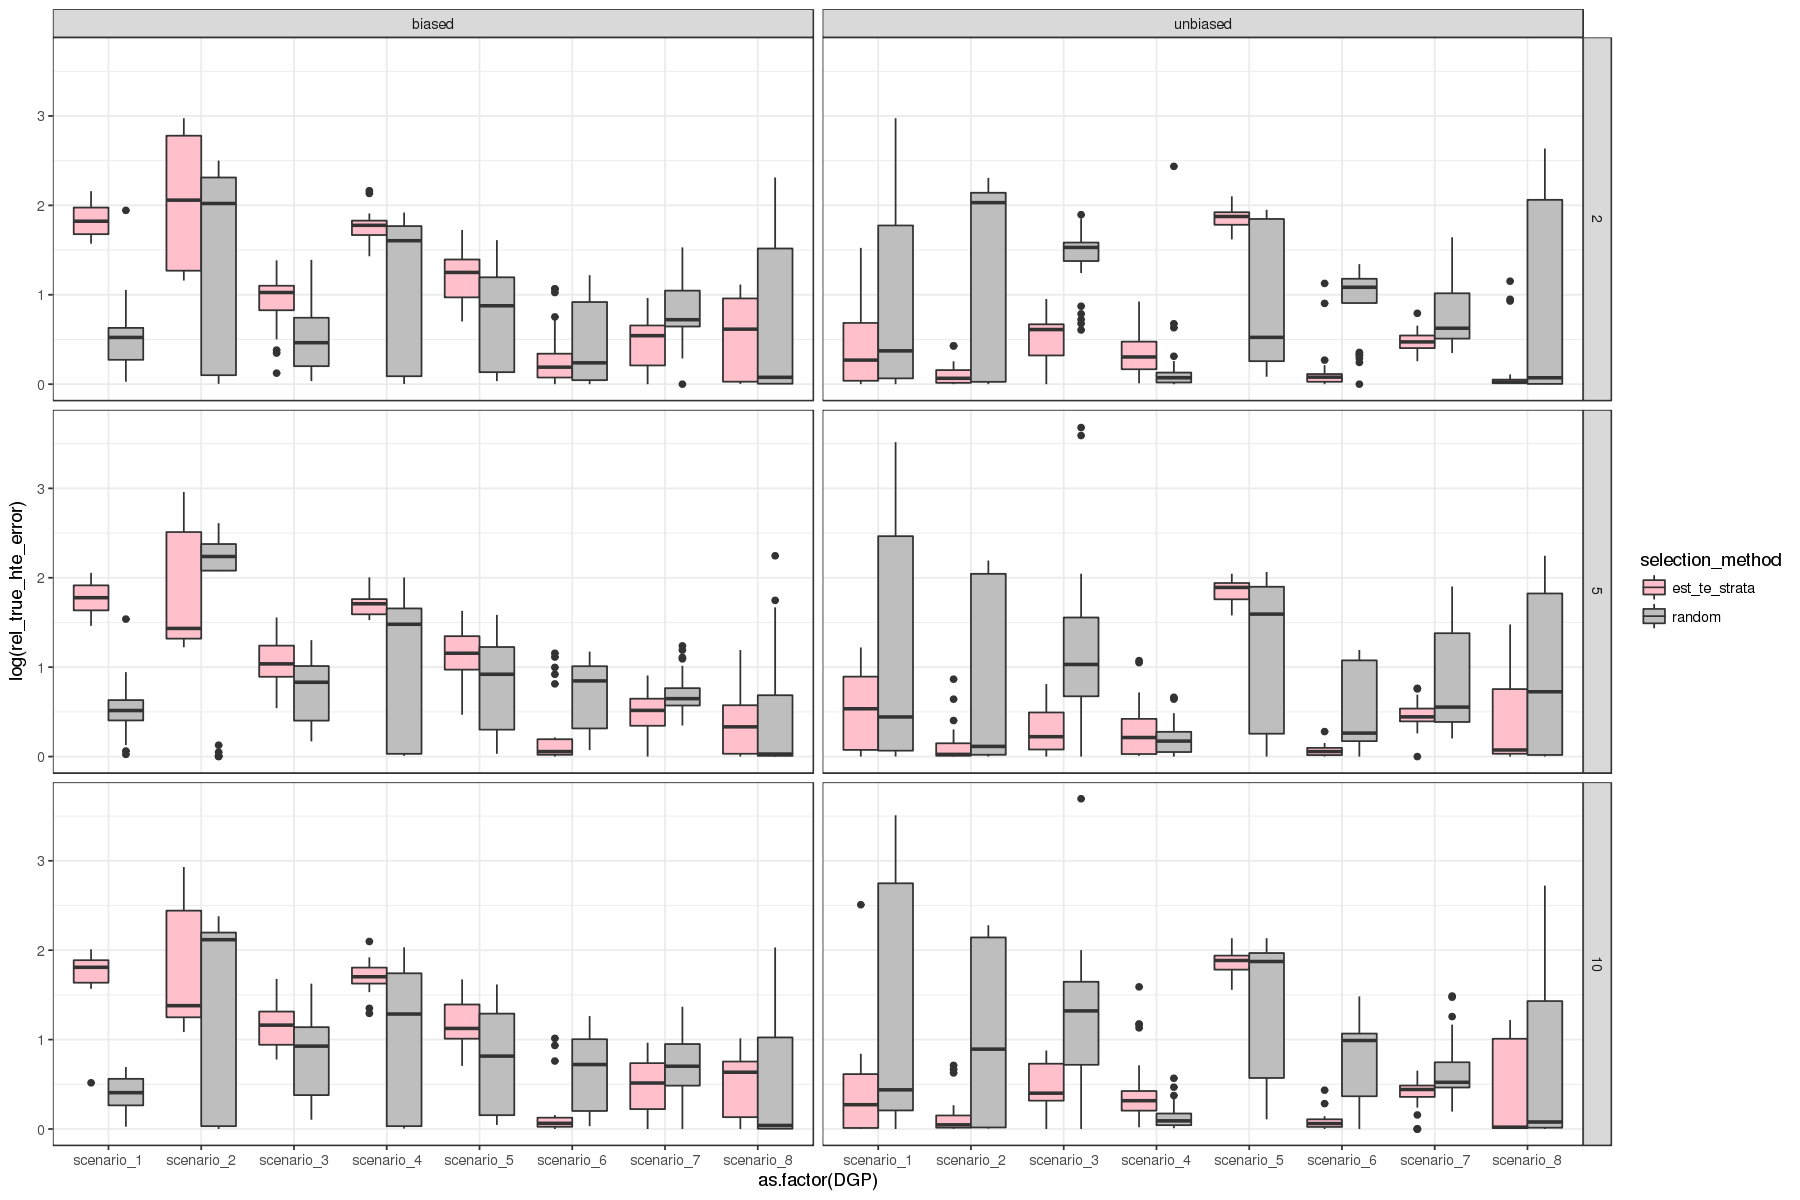

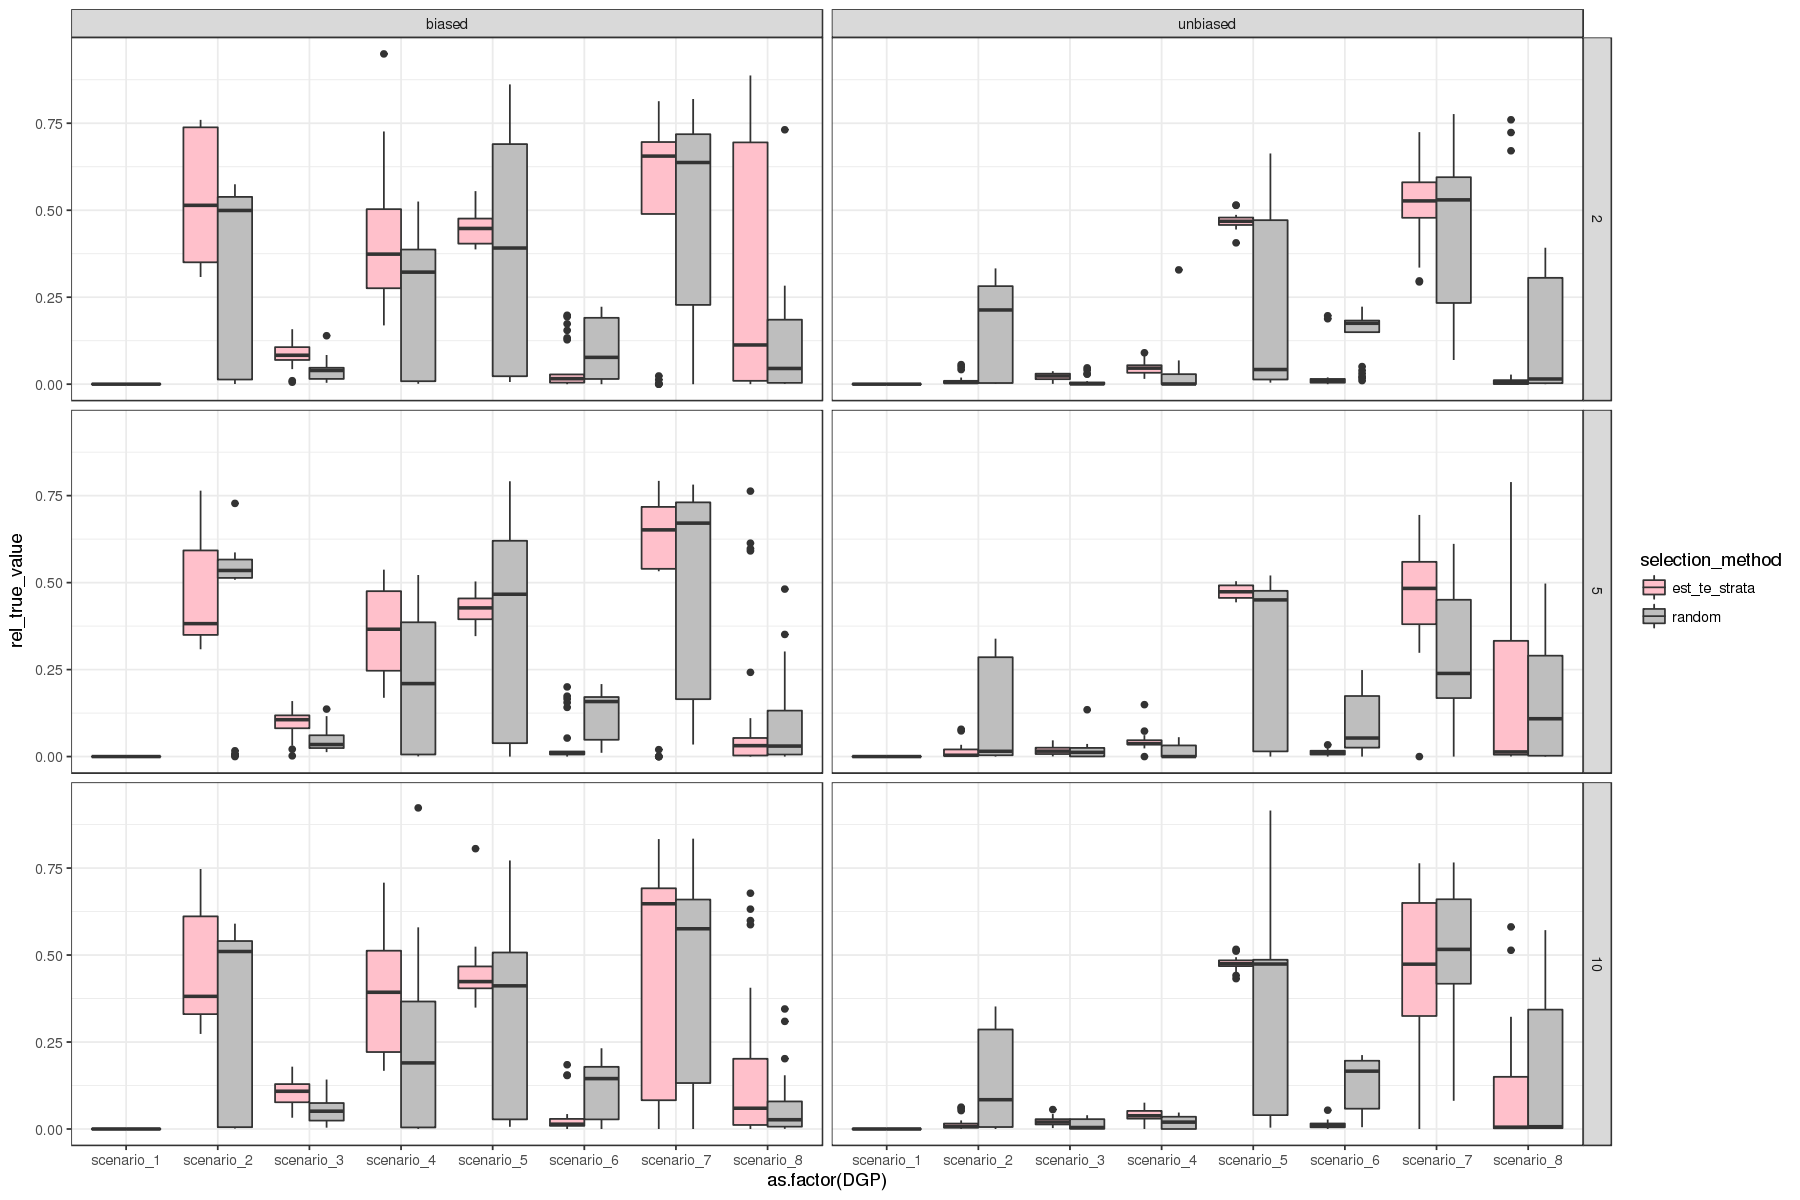

In [123]:
options(repr.plot.width=15, repr.plot.height=10)
rel_results %>%
filter(selection_method %in% misc_methods | selection_method == "random") %>%
ggplot(aes(x=as.factor(DGP), y=log(rel_true_hte_error), fill=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_colors) + 
    facet_grid(n_folds~assignment) + 
    theme_bw()

rel_results %>%
filter(selection_method %in% misc_methods | selection_method == "random") %>%
ggplot(aes(x=as.factor(DGP), y=rel_true_value, fill=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_colors) + 
    facet_grid(n_folds~assignment) + 
    theme_bw()

`random` often beats Rob's method, even with unbiased assignment

# Winner's Bracket

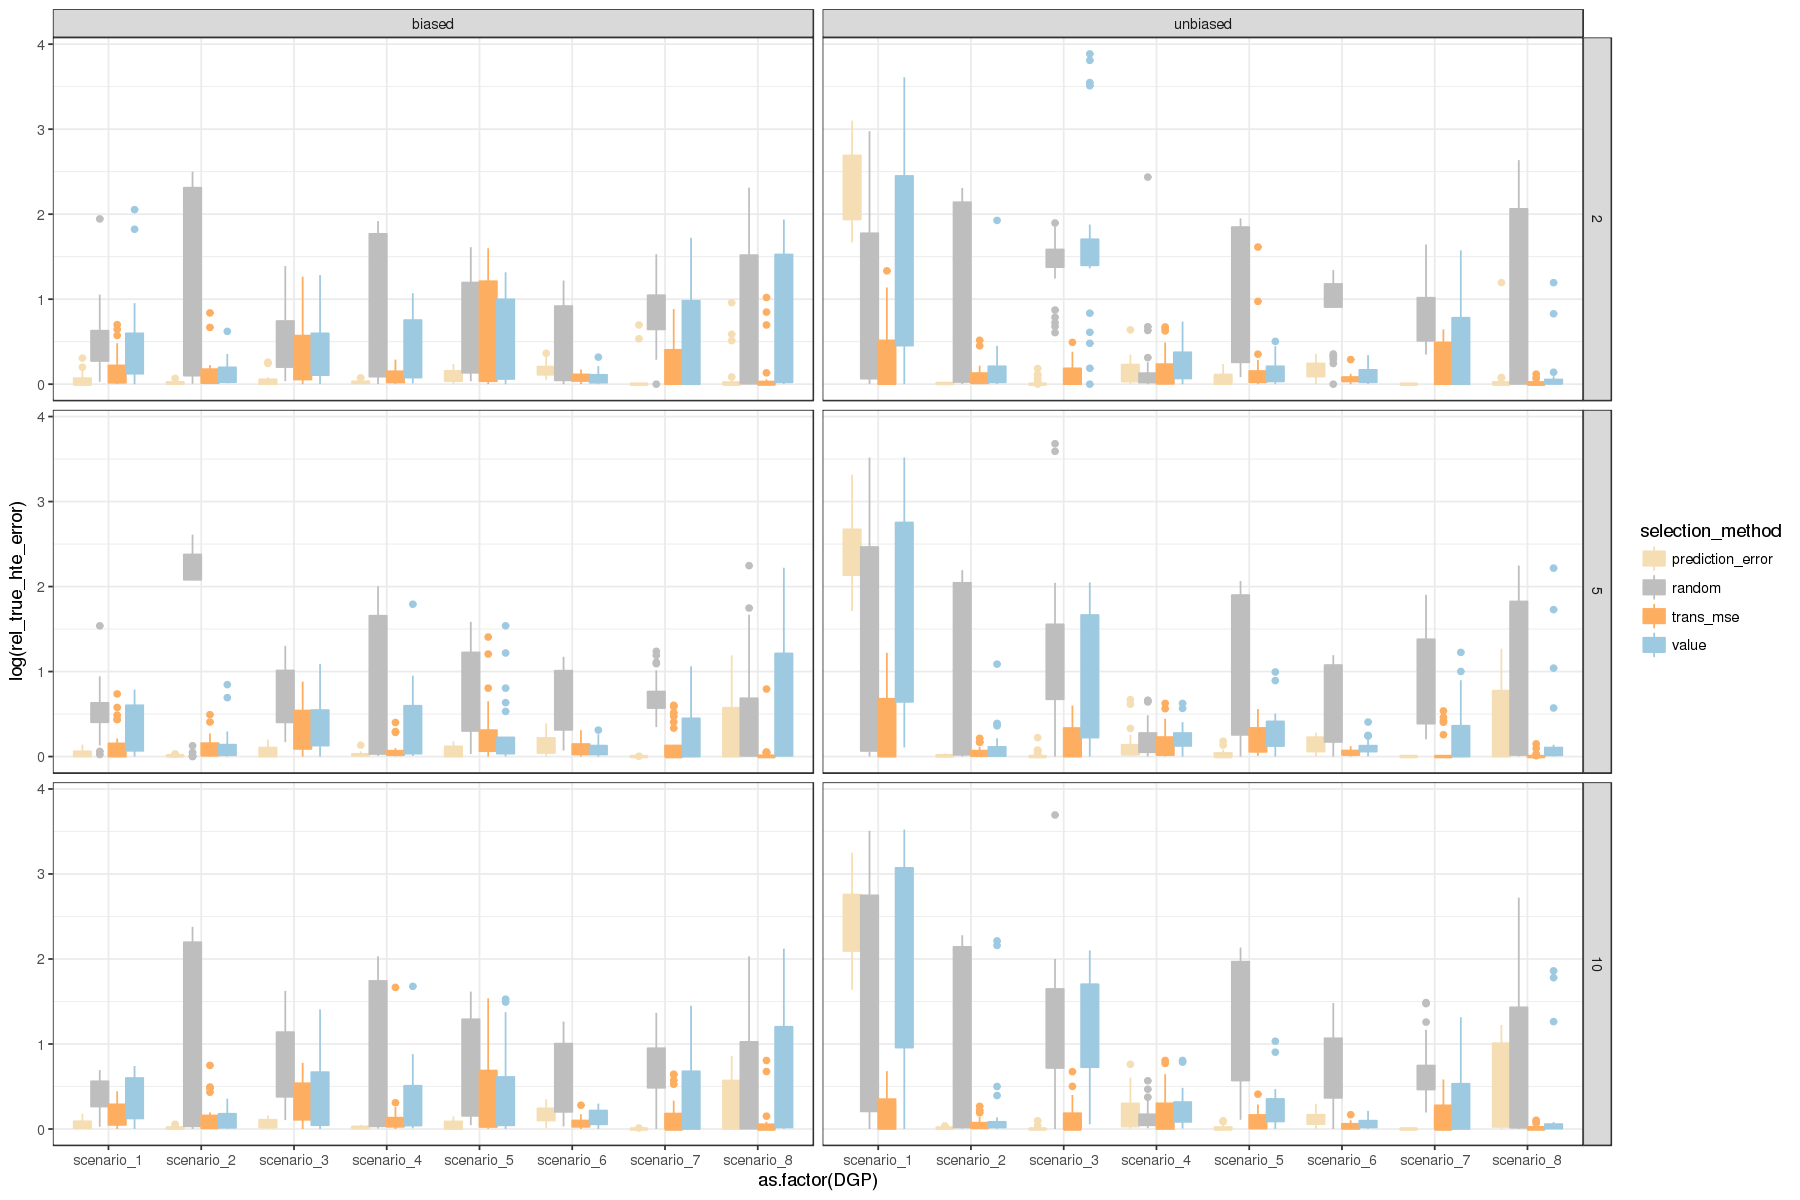

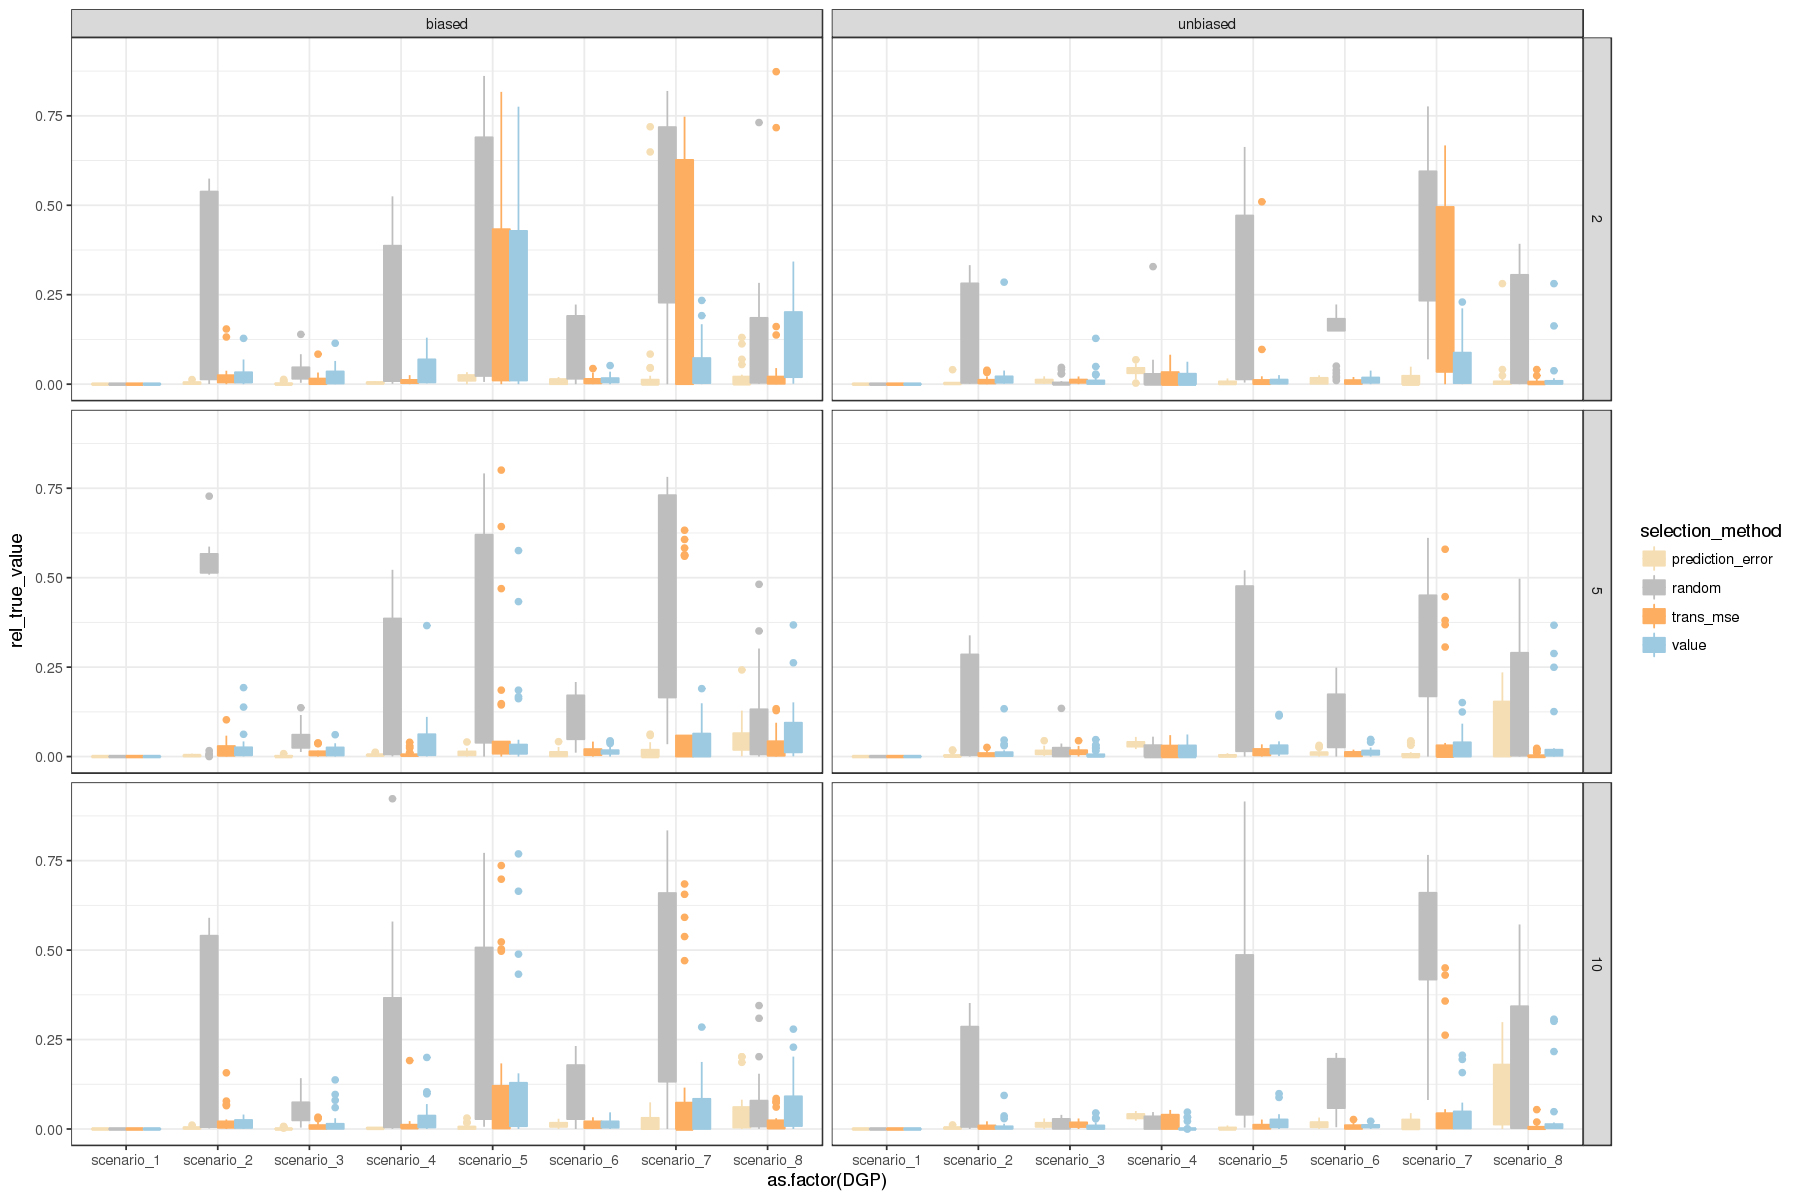

In [129]:
winner_methods = c("trans_mse", "value", "prediction_error", "random")

rel_results %>%
filter(selection_method %in% winner_methods) %>%
ggplot(aes(x=as.factor(DGP), y=log(rel_true_hte_error), fill=selection_method, color=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_colors) + 
    scale_color_manual(values = method_colors) + 
    facet_grid(n_folds~assignment) + 
    theme_bw()

rel_results %>%
filter(selection_method %in% winner_methods) %>%
ggplot(aes(x=as.factor(DGP), y=rel_true_value, fill=selection_method, color=selection_method)) +
    geom_boxplot() +
    scale_fill_manual(values = method_colors) + 
    scale_color_manual(values = method_colors) + 
    facet_grid(n_folds~assignment) + 
    theme_bw()

`trans_mse` and `prediction_error` are the winners here.